# Imports

In [146]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import ndcg_score

import random

import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Set random seed

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

In [3]:
seed = 1234
set_seed(seed)

# Prepare data

## Load dataset

In [41]:
# https://www.kaggle.com/competitions/kkbox-music-recommendation-challenge/data

train_df = pd.read_csv('data/train.csv')

In [42]:
members_df = pd.read_csv('data/members.csv')

In [43]:
songs_df = pd.read_csv('data/songs.csv')

## Exploratory Data Analysis

### Dataset content

In [7]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


**Датасет взаимодействий (`train.csv`)**:
- `msno`: идентификатор пользователя.
- `song_id`: идентификатор песни.
- `source_system_tab`: вкладка системы, из которой инициировано взаимодействие.
- `source_screen_name`: название экрана, с которого произошло взаимодействие.
- `source_type`: тип источника (например, плейлист).
- `target`: целевая переменная, где `1` означает, что пользователь положительно взаимодействовал с треком (например, добавил в плейлист), а `0` — что не было такого взаимодействия.

In [8]:
train_df.shape

(7377418, 6)

In [10]:
print(train_df[train_df.duplicated].shape[0])

0


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   msno                object
 1   song_id             object
 2   source_system_tab   object
 3   source_screen_name  object
 4   source_type         object
 5   target              int64 
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


In [12]:
members_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


**Датасет пользователей (`members.csv`)**:
- `msno`: уникальный идентификатор пользователя.
- `city`: город пользователя.
- `bd`: возраст пользователя.
- `gender`: пол пользователя.
- `registered_via`: метод регистрации.
- `registration_init_time`: дата регистрации.
- `expiration_date`: дата истечения подписки.

In [13]:
members_df.shape

(34403, 7)

In [14]:
print(members_df[members_df.duplicated].shape[0])

0


In [15]:
members_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-null  int64 
 6   expiration_date         34403 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


In [16]:
songs_df.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


**Датасет песен (`songs.csv`)**:
- `song_id`: уникальный идентификатор песни.
- `song_length`: длительность песни в миллисекундах.
- `genre_ids`: идентификаторы жанров.
- `artist_name`: имя исполнителя.
- `composer`: композитор.
- `lyricist`: автор текста.
- `language`: язык песни.

In [17]:
songs_df.shape

(2296320, 7)

In [18]:
print(songs_df[songs_df.duplicated].shape[0])

0


In [19]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   song_id      object 
 1   song_length  int64  
 2   genre_ids    object 
 3   artist_name  object 
 4   composer     object 
 5   lyricist     object 
 6   language     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


In [20]:
train_df.target.value_counts()

target
1    3714656
0    3662762
Name: count, dtype: int64

<Axes: >

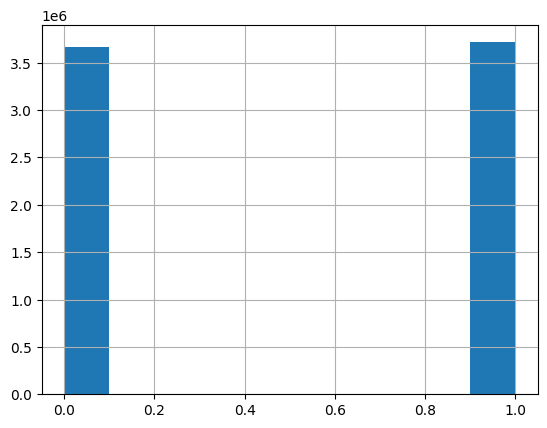

In [21]:
train_df.target.hist()

### Visualize features

<Axes: >

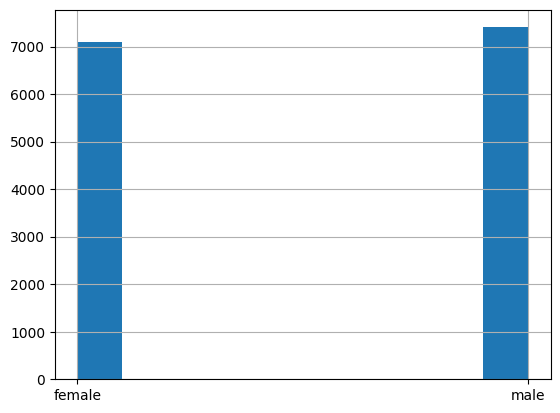

In [22]:
members_df.gender.hist()

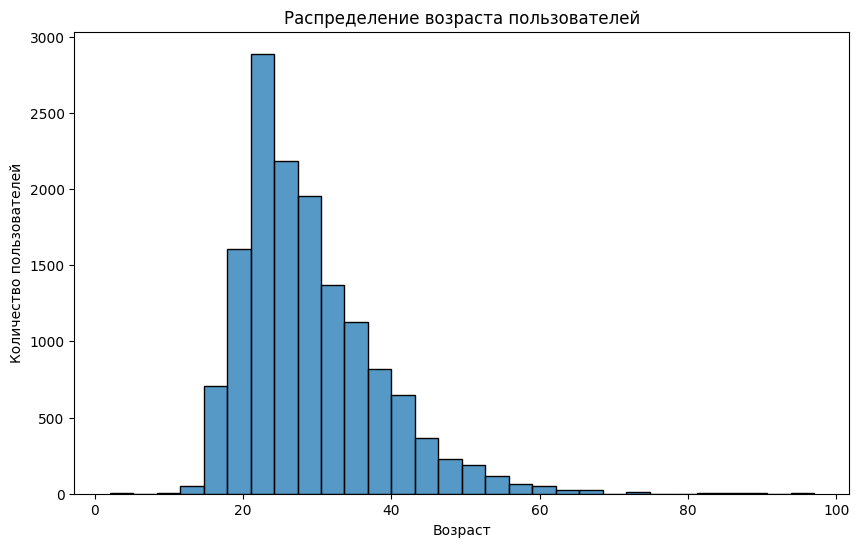

In [23]:
# Фильтрация данных, исключая нулевые значения для возраста и ограничивая возраст разумными значениями
filtered_data = members_df[(members_df['bd'] > 0) & (members_df['bd'] <= 100)]

# Визуализация распределения возраста
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['bd'], bins=30, kde=False)
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

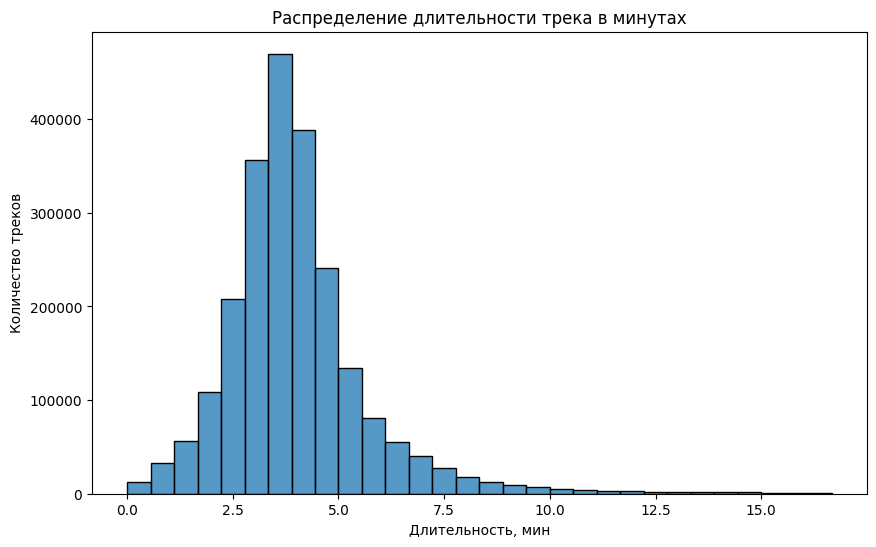

In [24]:
filtered_data = songs_df[(songs_df['song_length'] > 0) & (songs_df['song_length'] <= 1e6)]

# Визуализация распределения длительности трека
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['song_length'] / 60000, bins=30, kde=False)
plt.title('Распределение длительности трека в минутах')
plt.xlabel('Длительность, мин')
plt.ylabel('Количество треков')
plt.show()

In [25]:
# Определим функцию для отрисовки гистограммы для конкретного признака
def plot_top_categories(df, column, top_n=8):
    plt.figure(figsize=(6, 3))
    data = df[column].value_counts().head(top_n)
    sns.barplot(x=data.values, y=data.index, palette="viridis")
    plt.title(f'Топ-{top_n} значений для признака {column}')
    plt.xlabel('Количество')
    plt.ylabel(column)

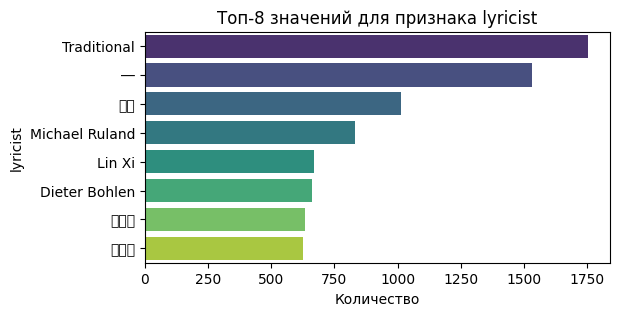

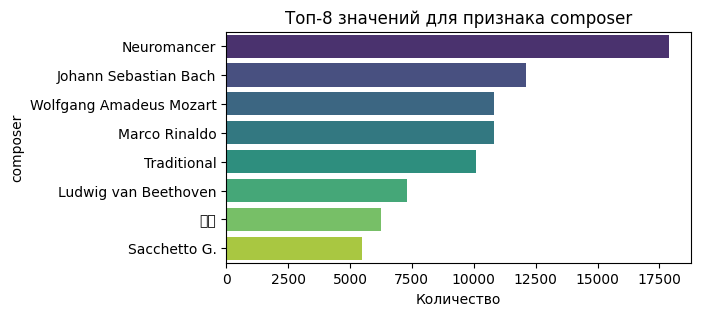

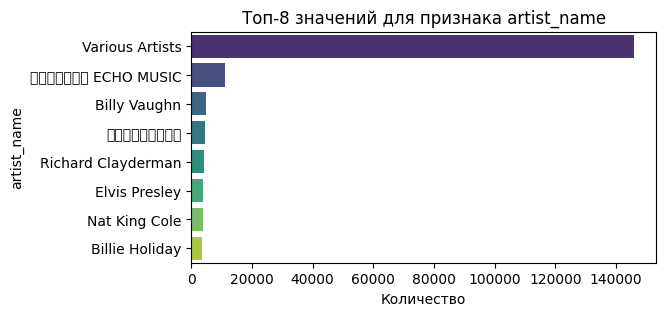

In [26]:
# Для каждого интересующего признака вызовем эту функцию
# Для датасета songs
plot_top_categories(songs_df, 'lyricist')
plot_top_categories(songs_df, 'composer')
plot_top_categories(songs_df, 'artist_name')

plt.show()

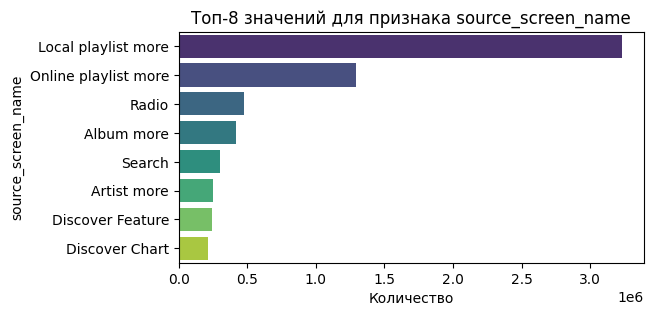

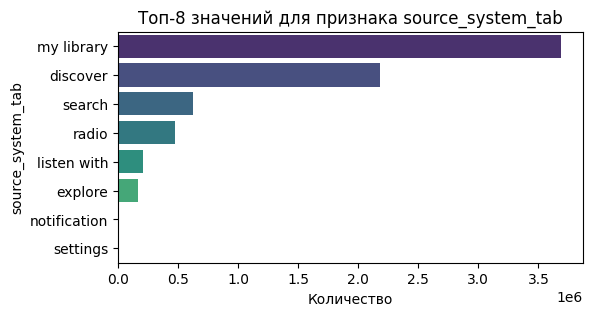

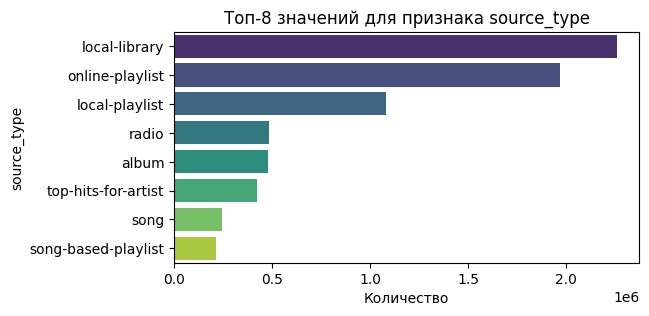

In [27]:
# Для датасета train
plot_top_categories(train_df, 'source_screen_name')
plot_top_categories(train_df, 'source_system_tab')
plot_top_categories(train_df, 'source_type')

plt.show()

### Missing value

In [28]:
def summarize_missing_data(df):
    # Создаем DataFrame для суммарной информации
    summary = pd.DataFrame(df.dtypes, columns=['dtype'])
    
    # Количество уникальных значений в каждом столбце
    summary['unique_values'] = df.nunique()
    
    # Количество пропущенных значений в каждом столбце
    summary['missing_values'] = df.isnull().sum()
    
    # Процент пропущенных значений
    summary['missing_percentage'] = (summary['missing_values'] / len(df)) * 100
    
    # Количество нулевых значений в каждом столбце
    summary['zero_values'] = (df == 0).sum()
    
    # Процент нулевых значений
    summary['zero_percentage'] = (summary['zero_values'] / len(df)) * 100
    
    # Сортировка таблицы по количеству пропущенных значений в порядке убывания
    summary = summary.sort_values(by='missing_percentage', ascending=False)
    
    return summary

In [29]:
summary_members = summarize_missing_data(members_df)
summary_songs = summarize_missing_data(songs_df)
summary_train = summarize_missing_data(train_df)

In [30]:
summary_members.style.background_gradient(cmap='YlOrRd',axis=0)

,dtype,unique_values,missing_values,missing_percentage,zero_values,zero_percentage
gender,object,2,19902,57.849606,0,0.000000
msno,object,34403,0,0.000000,0,0.000000
city,int64,21,0,0.000000,0,0.000000
bd,int64,95,0,0.000000,19932,57.936808
registered_via,int64,6,0,0.000000,0,0.000000
registration_init_time,int64,3862,0,0.000000,0,0.000000
expiration_date,int64,1484,0,0.000000,0,0.000000


In [31]:
summary_songs.style.background_gradient(cmap='YlOrRd',axis=0)

,dtype,unique_values,missing_values,missing_percentage,zero_values,zero_percentage
lyricist,object,110924,1945306,84.714064,0,0.000000
composer,object,329822,1071358,46.655431,0,0.000000
genre_ids,object,1045,94116,4.098558,0,0.000000
language,float64,10,1,0.000044,0,0.000000
song_id,object,2296320,0,0.000000,0,0.000000
song_length,int64,146534,0,0.000000,0,0.000000
artist_name,object,222363,0,0.000000,0,0.000000


In [32]:
summary_train.style.background_gradient(cmap='YlOrRd',axis=0)

,dtype,unique_values,missing_values,missing_percentage,zero_values,zero_percentage
source_screen_name,object,20,414804,5.622618,0,0.000000
source_system_tab,object,8,24849,0.336825,0,0.000000
source_type,object,12,21539,0.291959,0,0.000000
msno,object,30755,0,0.000000,0,0.000000
song_id,object,359966,0,0.000000,0,0.000000
target,int64,2,0,0.000000,3662762,49.648292


In [33]:
is_in_members = train_df['msno'].isin(members_df['msno'])
is_in_members[is_in_members == False].count()

0

In [34]:
is_in_songs = train_df['song_id'].isin(songs_df['song_id'])
is_in_songs[is_in_songs == False].count()

114

In [44]:
train_df = train_df.loc[is_in_songs]

## Merge datasets

In [45]:
# del df

In [46]:
# Объединение результата с songs_data
df = pd.merge(train_df, songs_df, on='song_id', how='left')

# Объединение train_data с members_data
df = pd.merge(df, members_df, on='msno', how='left')

In [47]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584,1259,Various Artists,NaN,NaN,52.0,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,1,0,NaN,7,20120102,20171005


In [48]:
del train_df
del members_df
del songs_df

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377304 entries, 0 to 7377303
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   msno                    object 
 1   song_id                 object 
 2   source_system_tab       object 
 3   source_screen_name      object 
 4   source_type             object 
 5   target                  int64  
 6   song_length             int64  
 7   genre_ids               object 
 8   artist_name             object 
 9   composer                object 
 10  lyricist                object 
 11  language                float64
 12  city                    int64  
 13  bd                      int64  
 14  gender                  object 
 15  registered_via          int64  
 16  registration_init_time  int64  
 17  expiration_date         int64  
dtypes: float64(1), int64(7), object(10)
memory usage: 1013.1+ MB


In [60]:
summary_full = summarize_missing_data(df)
summary_full.style.background_gradient(cmap='YlOrRd',axis=0)

,dtype,unique_values,missing_values,missing_percentage,zero_values,zero_percentage
lyricist,object,33887,3178698,43.087529,0,0.000000
gender,object,2,2961436,40.142524,0,0.000000
composer,object,76064,1675592,22.712796,0,0.000000
source_screen_name,object,20,414796,5.622596,0,0.000000
genre_ids,object,572,118341,1.604123,0,0.000000
source_system_tab,object,8,24849,0.336830,0,0.000000
source_type,object,12,21539,0.291963,0,0.000000
language,float64,10,36,0.000488,0,0.000000
city,int64,21,0,0.000000,0,0.000000
registration_init_time,int64,3811,0,0.000000,0,0.000000


## Split dataset

In [131]:
df_train, df_tmp = train_test_split(df, test_size=0.3, random_state=seed)
df_val, df_test = train_test_split(df_tmp, test_size=0.5, random_state=seed)

In [132]:
del df_tmp

In [133]:
df_train.shape, df_val.shape, df_test.shape

((5164112, 22), (1106596, 22), (1106596, 22))

## Correct data

In [80]:
def convert_date(df):
    # Конвертация столбцов в строковый тип, если они ещё не в этом формате
    df['registration_init_time'] = df['registration_init_time'].astype(str)
    df['expiration_date'] = df['expiration_date'].astype(str)
    
    # Извлечение года и месяца из registration_init_time
    df['registration_year'] = df['registration_init_time'].str.slice(0, 4).astype(int)
    df['registration_month'] = df['registration_init_time'].str.slice(4, 6).astype(int)
    
    # Извлечение года и месяца из expiration_date
    df['expiration_year'] = df['expiration_date'].str.slice(0, 4).astype(int)
    df['expiration_month'] = df['expiration_date'].str.slice(4, 6).astype(int)

    df = df.drop(columns=['registration_init_time', 'expiration_date'])

    return df

In [81]:
df_train = convert_date(df_train)
df_val = convert_date(df_val)
df_test = convert_date(df_test)

In [61]:
def fill_missing_values(df):
    """
    Заполняет пропущенные значения в DataFrame:
    - 'Unknown' для категориальных данных (тип object).
    - Интерполяция для числовых данных.
    """
    for column in df.columns:
        if df[column].dtype == 'object':  # Категориальные данные
            df[column].fillna('Unknown', inplace=True)
        else:  # Числовые данные
            df[column].interpolate(method='linear', inplace=True)
            # Если в начале или конце столбца все еще есть пропуски (крайние значения не интерполируются)
            df[column].fillna(method='bfill', inplace=True)  # Заполнение пропусков сзади на перед
            df[column].fillna(method='ffill', inplace=True)  # Заполнение пропусков спереди назад
    return df

In [70]:
def plot_boxplots(dataframe):
    """
    Plots boxplots for all numerical columns in the given dataframe.

    Args:
        dataframe (pandas.DataFrame): The input dataframe.

    Returns:
        None
    """
    # Get a list of all numerical columns in the dataframe
    num_columns = dataframe.select_dtypes(include=['number']).columns

    # Calculate the number of plots required
    num_plots = len(num_columns)

    # Determine the number of rows needed for the subplots
    rows = (num_plots + 1) // 2

    # Create a figure with the required number of subplots
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(20, 30))

    # Iterate over the numerical columns
    for i, column in enumerate(num_columns):
        # Calculate the row and column indices for the current subplot
        row = i // 2
        col = i % 2

        # Get the current subplot axis
        ax = axes[row, col]

        # Plot the boxplot for the current column
        sns.boxplot(x=dataframe[column], ax=ax)

        # Set the title and x-label for the current subplot
        ax.set_title(f"Boxplot of {column}")

    plt.show()

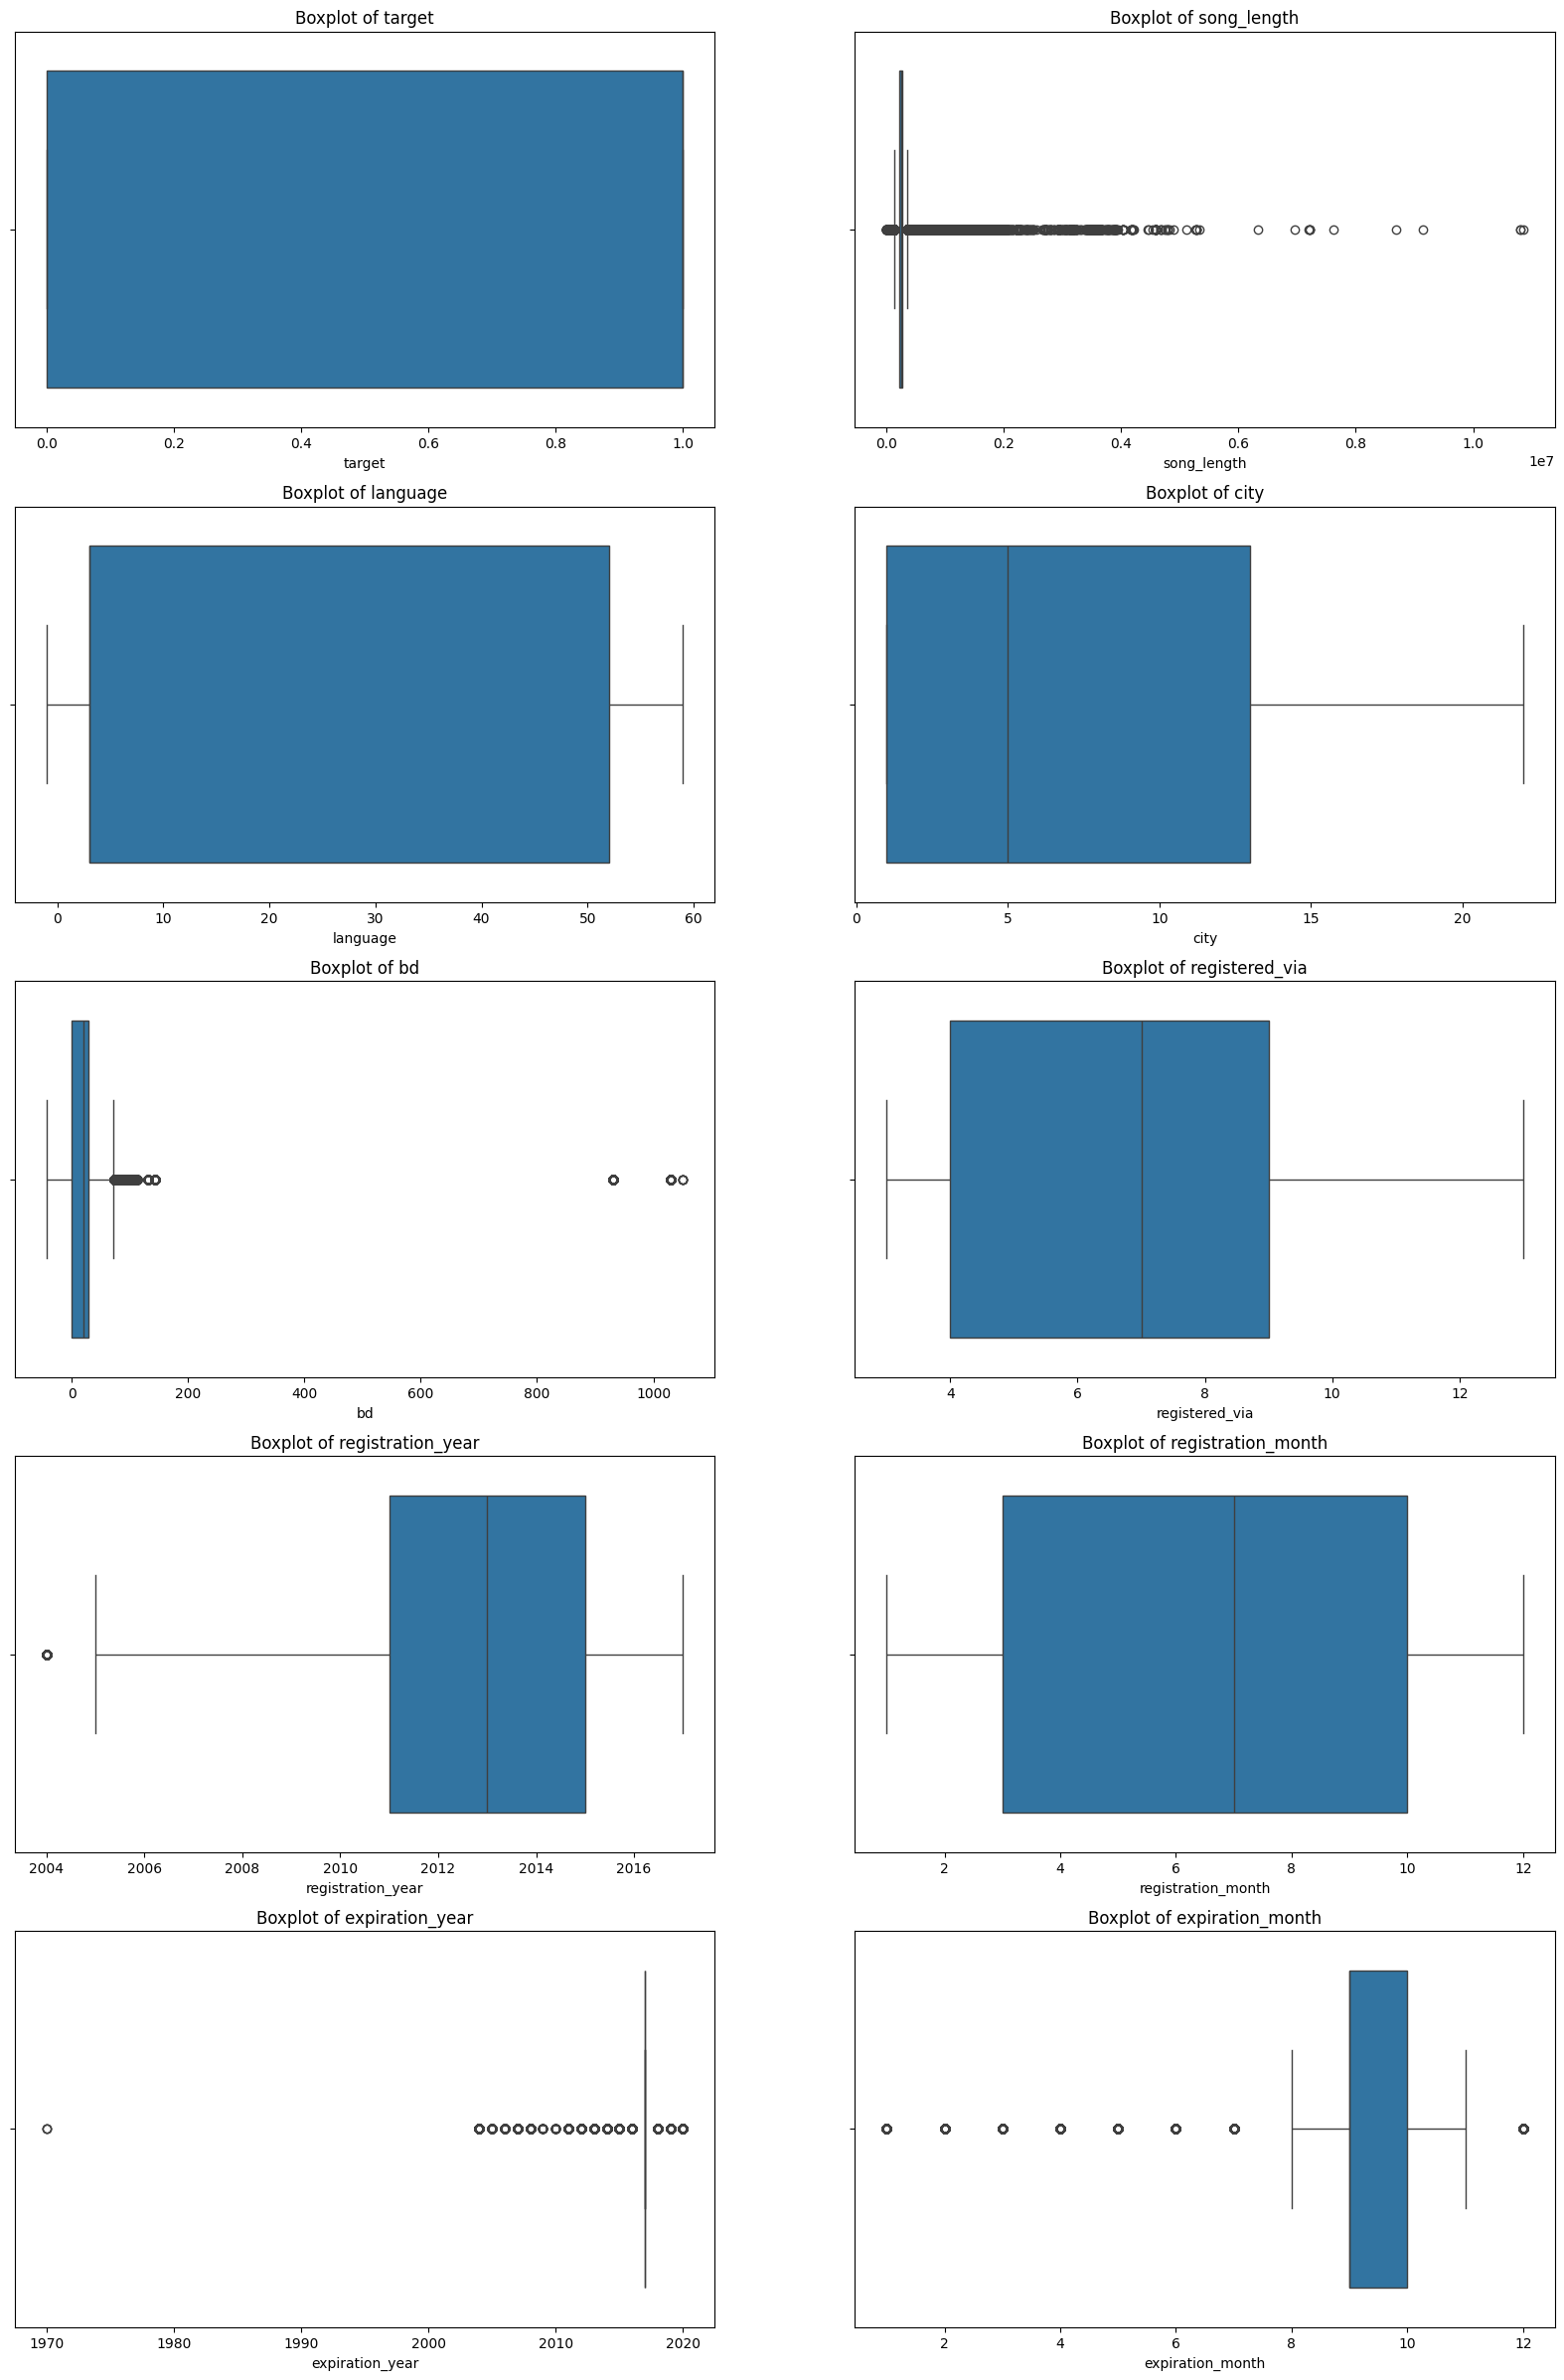

In [71]:
plot_boxplots(df_train)

In [73]:
def filter_outliers(df):
    """
    Фильтрует выбросы в DataFrame на основе заданных диапазонов для столбцов.
    """
    # Словарь с диапазонами допустимых значений для каждого столбца
    constraints = {
        'bd': (0, 100),             # Возраст от 0 до 100 лет
        'song_length': (0, 3e6),     # Длительность песни от 0 до 3,000,000 мс
        'expiration_year': (2000, None)
    }
    
    
    # Применение фильтров
    for column, (min_val, max_val) in constraints.items():
        if column in df.columns:
            if min_val is not None:
                df = df[df[column] >= min_val]
            if max_val is not None:
                df = df[df[column] <= max_val]
    
    return df

In [74]:
def replace_zero_age_with_median(df):
    median_age = df[df['bd'] > 0]['bd'].median()
    df['bd'] = df['bd'].replace(0, median_age)

    return df

In [85]:
def correct_data(df):
    df = fill_missing_values(df)
    df = filter_outliers(df)
    df = replace_zero_age_with_median(df)
    return df

In [115]:
def encode_data(df, ordinal_encoders=None):
    cols = df.columns[2:]
    
    if ordinal_encoders is None:
        ordinal_encoders = {}  
        for column in cols:
            if df[column].dtype == 'object': 
                oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
                oe.fit(pd.DataFrame(df[column]))  
                ordinal_encoders[column] = oe
    
    for column in cols:
        if df[column].dtype == 'object': 
            oe = ordinal_encoders[column]
            df[column] = oe.transform(pd.DataFrame(df[column]))

    return df, ordinal_encoders

In [116]:
def normalize_data(df, standard_scaler=None):
    cols = df.columns[2:]
    
    if standard_scaler is None:
        standard_scaler = StandardScaler()
        standard_scaler.fit(df[cols])
    df[cols] = standard_scaler.transform(df[cols])

    return df, standard_scaler

In [117]:
def prepare_data(df, ordinal_encoders=None, standard_scaler=None):
    df = correct_data(df)
    df, ordinal_encoders = encode_data(df, ordinal_encoders)
    # df, standard_scaler = normalize_data(df, standard_scaler)

    return df, ordinal_encoders, standard_scaler

In [134]:
df_train_prep, ordinal_encoders, standard_scaler = prepare_data(df_train)

In [135]:
df_val_prep, _, _ = prepare_data(df_val, ordinal_encoders, standard_scaler)
df_test_prep, _, _ = prepare_data(df_test, ordinal_encoders, standard_scaler)

In [136]:
df_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5158965 entries, 1309520 to 486191
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   msno                    object 
 1   song_id                 object 
 2   source_system_tab       float64
 3   source_screen_name      float64
 4   source_type             float64
 5   target                  int64  
 6   song_length             int64  
 7   genre_ids               float64
 8   artist_name             float64
 9   composer                float64
 10  lyricist                float64
 11  language                float64
 12  city                    int64  
 13  bd                      int64  
 14  gender                  float64
 15  registered_via          int64  
 16  registration_init_time  float64
 17  expiration_date         float64
 18  registration_year       int32  
 19  registration_month      int32  
 20  expiration_year         int32  
 21  expiration_month        int32  

# Modeling

## Create and train

In [137]:
# Сортировка данных
df_train_prep.sort_values(by=['msno', 'song_id'], inplace=True)
df_val_prep.sort_values(by=['msno', 'song_id'], inplace=True)
df_test_prep.sort_values(by=['msno', 'song_id'], inplace=True)

In [139]:
# Сохранение msno и song_id в отдельную переменную и удаление из основных данных
train_pairs = df_train_prep[['msno', 'song_id']]
val_pairs = df_val_prep[['msno', 'song_id']]
test_pairs = df_test_prep[['msno', 'song_id']]

In [144]:
df_train_prep.drop(columns=['msno', 'song_id'], inplace=True)
df_val_prep.drop(columns=['msno', 'song_id'], inplace=True)
df_test_prep.drop(columns=['msno', 'song_id'], inplace=True)

In [147]:
# Подготовка данных для XGBoost
dtrain = xgb.DMatrix(df_train_prep.drop('target', axis=1), label=df_train_prep['target'])
dval = xgb.DMatrix(df_val_prep.drop('target', axis=1), label=df_val_prep['target'])

In [153]:
# Параметры модели
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist',
    'predictor': 'cpu_predictor'
}

In [154]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=10000,  # максимальное число деревьев
    evals=[(dval, 'validation')],
    early_stopping_rounds=10  # ранняя остановка после 10 раундов без улучшений
)

[0]	validation-auc:0.66140
[1]	validation-auc:0.66467
[2]	validation-auc:0.66776
[3]	validation-auc:0.66975
[4]	validation-auc:0.67105
[5]	validation-auc:0.67266
[6]	validation-auc:0.67326
[7]	validation-auc:0.67478
[8]	validation-auc:0.67552
[9]	validation-auc:0.67704
[10]	validation-auc:0.67791
[11]	validation-auc:0.67849
[12]	validation-auc:0.67893
[13]	validation-auc:0.68005
[14]	validation-auc:0.68159
[15]	validation-auc:0.68260
[16]	validation-auc:0.68310
[17]	validation-auc:0.68357
[18]	validation-auc:0.68370
[19]	validation-auc:0.68435
[20]	validation-auc:0.68486
[21]	validation-auc:0.68559
[22]	validation-auc:0.68625
[23]	validation-auc:0.68702
[24]	validation-auc:0.68761
[25]	validation-auc:0.68811
[26]	validation-auc:0.68845
[27]	validation-auc:0.68912
[28]	validation-auc:0.68978
[29]	validation-auc:0.69054
[30]	validation-auc:0.69115
[31]	validation-auc:0.69144
[32]	validation-auc:0.69165
[33]	validation-auc:0.69213
[34]	validation-auc:0.69251
[35]	validation-auc:0.69293
[3

In [155]:
model.save_model('model.json')

## Test

In [156]:
def ndcg_at_k(y_true, y_score, qid, k=10):
    """
    Calculates Normalized Discounted Cumulative Gain (NDCG@k)
    for given true relevancies, predicted scores, and query IDs.

    Args:
        y_true (List[int]): List of true relevancies (0 or 1)
        y_score (List[float]): List of predicted relevance scores
        qid (List[int]): List of query identifiers
        k (int, optional): Number of top results to consider. Default is 10.

    Returns:
        float: The NDCG@k value, averaged across all queries
    """
    queries = sorted(set(qid))  # Unique query identifiers
    ndcg_scores = []

    for q in queries:
        q_mask = np.array(qid) == q  # Mask for the current query
        q_y_true = np.array(y_true)[q_mask]  # True relevancies for the query
        q_y_score = np.array(y_score)[q_mask]  # Predicted scores for the query

        # Sort by descending predicted scores
        sort_idx = np.argsort(-q_y_score)
        q_y_true = q_y_true[sort_idx]
        q_y_score = q_y_score[sort_idx]

        # Skip queries with only one document
        if len(q_y_true) <= 1:
            continue

        # Calculate NDCG@k using ndcg_score
        ndcg = ndcg_score([q_y_true.flatten()], [q_y_score], k=k)
        ndcg_scores.append(ndcg)

    if not ndcg_scores:
        return 0.0  # If all queries have only one document
    else:
        return np.mean(ndcg_scores)

In [157]:
y_test = df_test_prep['target']

In [159]:
dtest = xgb.DMatrix(df_test_prep.drop('target', axis=1))

In [160]:
y_pred = model.predict(dtest)

In [163]:
qid = test_pairs.msno

In [165]:
ndcg20 = ndcg_at_k(y_test, y_pred, qid, k=20)

In [167]:
print(f"NDCG@5: {ndcg20}")

NDCG@5: 0.7074054163367348
